# Sentiment analysis
# binary calssifiation

In [1]:
import shutil

import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from webencodings import labels

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, extract=True, cache_dir= '.',
    cache_subdir = '')

In [3]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
#load dataset
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds =tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("review", text_batch.numpy()[i])
        print("label", label_batch.numpy()[i])

review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [132]:
class_names= raw_train_ds.class_names
print(class_names)

['neg', 'pos']


In [10]:
raw_valid_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


prepare dataset for training

Standardize, Tokenize and vectorize

In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    tripped_html = tf.strings.regex_replace(lowercase, '<br />', '')
    return tf.strings.regex_replace(tripped_html, '[%s]' % re.escape(string.punctuation), '')

In [106]:
max_features = 10000
sequence_length = 250
vectorized_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [107]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorized_layer.adapt(train_text)

In [15]:
# create a function to see the result of using this layer to preprocess some data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorized_layer(text),label

In [16]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print("Label", first_label)
print("Vectorized Review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [17]:
print("1287 ---> ",vectorized_layer.get_vocabulary()[166])
print(" 313 ---> ",vectorized_layer.get_vocabulary()[291])
print('Vocabulary size: {}'.format(len(vectorized_layer.get_vocabulary())))

1287 --->  every
 313 --->  together
Vocabulary size: 10000


In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_valid_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
embedding_dim = 16

In [59]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [62]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - binary_accuracy: 0.5844 - loss: 0.6801 - val_binary_accuracy: 0.7452 - val_loss: 0.6093
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.7596 - loss: 0.5766 - val_binary_accuracy: 0.8102 - val_loss: 0.4984
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8226 - loss: 0.4668 - val_binary_accuracy: 0.8296 - val_loss: 0.4297
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8483 - loss: 0.3972 - val_binary_accuracy: 0.8324 - val_loss: 0.3951
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8676 - loss: 0.3518 - val_binary_accuracy: 0.8432 - val_loss: 0.3666
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8787 - loss: 0.3195 - val_binary_accuracy: 0.8486 - val_loss: 0.3485
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8899 - loss: 0.2944 - val_binary_accuracy: 0.8454 - val_loss: 0.3433
Epoch 

In [63]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - binary_accuracy: 0.8488 - loss: 0.3417
Loss:  0.34080570936203003
Accuracy:  0.8493599891662598


In [64]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

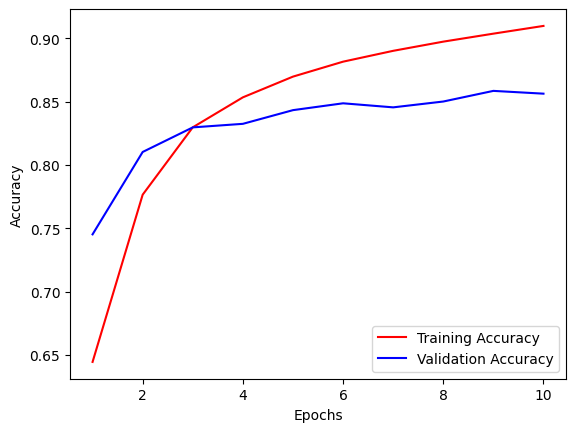

In [65]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

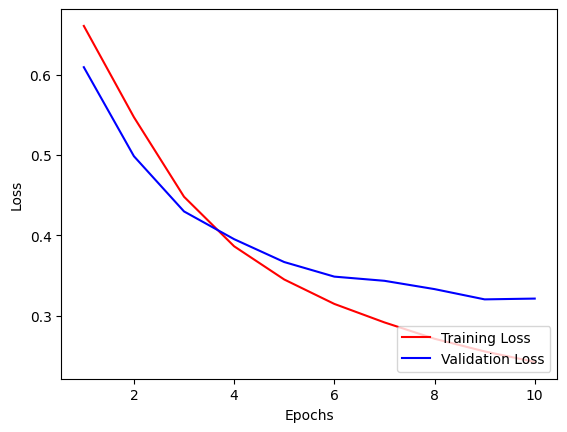

In [66]:

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

Export Model

The model will be capable to take string input.

Add TextVectorization layer to the trained model

In [108]:
export_model = tf.keras.Sequential([
    vectorized_layer,
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4992 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5, 'binary_accuracy': 0.0, 'loss': 0.0}


In [176]:
examples = tf.constant([
  "The movie is bad"
])

# predict=export_model.predict(examples)

In [177]:
# # For binary classification
# import numpy as np
# predicted_id = np.argmax(predict, axis=1)
# predicted_label = class_names[predicted_id[0]]
# 



In [178]:
# print(predicted_label)

In [192]:

# Sample text data
texts = tf.constant(["Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as ""Teachers"". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is ""Teachers"". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!"])

# Initialize the TextVectorization layer
vectorize_layer = layers.TextVectorization(
    max_tokens=100,
    output_mode="int",
    output_sequence_length=10  # Truncate or pad sequences to this length
)

# Adapt the layer to the dataset
vectorize_layer.adapt(texts)

# Convert text to sequences of integers
vectorized_text = vectorize_layer(texts)
print("Vectorized Text:", vectorized_text)

# If you want to see the vocabulary
vocab = vectorize_layer.get_vocabulary()
print("Vocabulary:", vocab)



Vectorized Text: tf.Tensor([[10  9  7 11 83 80 18 52 20  2]], shape=(1, 10), dtype=int64)
Vocabulary: ['', '[UNK]', 'the', 'to', 'that', 'teachers', 'of', 'is', 'i', 'high', 'bromwell', 'a', 'their', 'students', 'student', 'school', 'my', 'me', 'it', 'in', 'at', 'as', 'your', 'years', 'whole', 'who', 'which', 'when', 'what', 'welcome', 'tried', 'time', 'through', 'think', 'than', 'teaching', 'survive', 'such', 'some', 'situation', 'see', 'scramble', 'schools', 'saw', 'satire', 'same', 'sack', 'right', 'repeatedly', 'remind', 'recalled', 'reality', 'ran', 'programs', 'profession', 'pomp', 'pity', 'pettiness', 'pathetic', 'other', 'one', 'much', 'many', 'line', 'life', 'lead', 'knew', 'isnt', 'inspector', 'insightful', 'immediately', 'im', 'highs', 'here', 'financially', 'fetched', 'far', 'expect', 'episode', 'down', 'comedy', 'closer', 'classic', 'cartoon', 'can', 'burn', 'believe', 'and', 'all', 'age', 'adults', 'about', '35']


In [193]:
predictions = model.predict(vectorized_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [194]:
import numpy as np
predicted_id = np.argmax(predictions, axis=1)
predicted_class = class_names[predicted_id[0]]
print(predicted_class)

neg
